In [406]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [432]:
# Dataset'i yükleme
data = pd.read_csv('diabetes_prediction_dataset.csv')

# Özellik ve hedef değişkeni ayırma
X = data.drop(columns='diabetes')
y = data['diabetes']

# Kategorik sütunları belirleme (object veya category tipi)
#categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Kategorik sütunları one-hot encoding ile dönüştürme
X = pd.get_dummies(X)

# Normalizasyon
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# SMOTE uygulama
smote = SMOTE(sampling_strategy=0.3, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Veri seti boyutlarını gözlemleme
print(f"Eğitim seti boyutu: {X_train.shape}, Test seti boyutu: {X_test.shape}")
print("\n")
print("SMOTE sonrası sınıf dağılımı:")
print(pd.Series(y_train_smote).value_counts())


Eğitim seti boyutu: (80000, 15), Test seti boyutu: (20000, 15)


SMOTE sonrası sınıf dağılımı:
diabetes
0    73208
1    21962
Name: count, dtype: int64


In [472]:
print("Modelde kullanılan sütun isimleri:")
print(X.columns.tolist())

Modelde kullanılan sütun isimleri:
['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'gender_Female', 'gender_Male', 'gender_Other', 'smoking_history_No Info', 'smoking_history_current', 'smoking_history_ever', 'smoking_history_former', 'smoking_history_never', 'smoking_history_not current']


In [442]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight

# MLP modelini tanımlama
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),  # İlk gizli katman (32 nöron, ReLU)
    Dense(16, activation='relu'),  # İkinci gizli katman (16 nöron, ReLU)
    Dense(1, activation='sigmoid')  # Çıkış katmanı (1 nöron, Sigmoid)
])

# Modelin derlenmesi
model.compile(optimizer=Adam(learning_rate=0.001),  # Optimizasyon algoritması
              loss='binary_crossentropy',          # Kayıp fonksiyonu
              metrics=['accuracy'])                # Performans ölçütü

# Modelin özeti
print(model.summary())

#Overfitting riskini önlemek için
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Modelin eğitimi
history = model.fit(X_train, y_train,
                    validation_split=0.2,  # Eğitim setinin %20'sini doğrulama için kullan
                    epochs=20,             # Eğitim için 20 iterasyon
                    batch_size=32,         # Her iterasyonda kullanılacak veri sayısı
                    verbose=1,             # Eğitim detaylarını göster
                    class_weight=class_weights_dict,
                    callbacks=[early_stop])

# Test setinde değerlendirme
y_pred = (model.predict(X_test) > 0.8).astype("int32")  # Tahminler (0 veya 1'e yuvarlanmış)
print("\nTest Sonuçları:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_75 (Dense)                │ (None, 32)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,057 (4.13 KB)

 Trainable params: 1,057 (4.13 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 454us/step - accuracy: 0.7630 - loss: 0.3656 - val_accuracy: 0.8849 - val_loss: 0.2476
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 477us/step - accuracy: 0.8811 - loss: 0.2456 - val_accuracy: 0.8733 - val_loss: 0.2604
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 434us/step - accuracy: 0.8822 - loss: 0.2301 - val_accuracy: 0.8926 - val_loss: 0.2122
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 472us/step - accuracy: 0.8872 - loss: 0.2150 - val_accuracy: 0.8863 - val_loss: 0.2206
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 502us/step - accuracy: 0.8898 - loss: 0.2068 - val_accuracy: 0.8959 - val_loss: 0.2019
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 492us/step - accuracy: 0.8888 - loss: 0.2013 - val_accuracy: 0.8938 - val_loss: 0.2010
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 504us/step - accuracy: 0.8942 - loss: 0.1948 - val_accuracy: 0.8829 - val_loss: 0.2219
Epoch 8/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 438us/step - accuracy: 0.8

In [456]:
print(y_train.value_counts())


diabetes
0    73208
1     6792
Name: count, dtype: int64


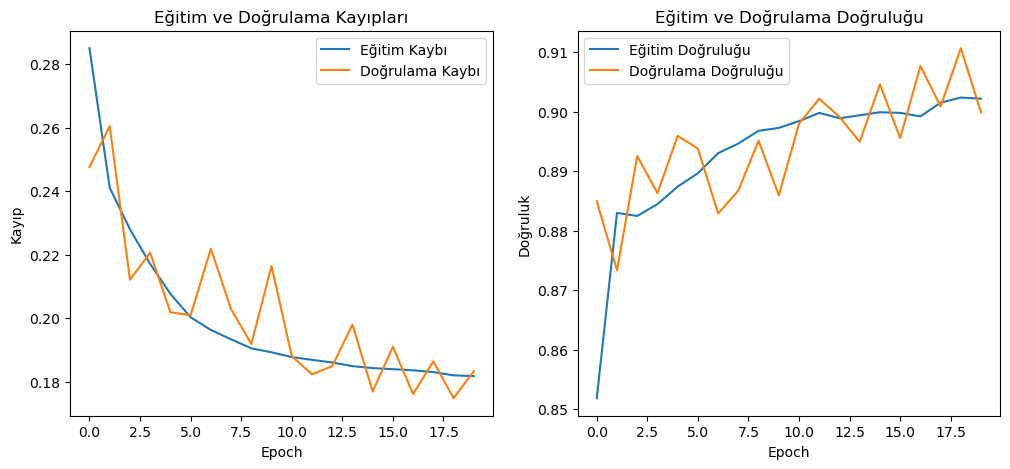

In [458]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama kayıplarını çizdirme
plt.figure(figsize=(12, 5))

# Eğitim ve doğrulama kayıpları
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim ve Doğrulama Kayıpları')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

# Eğitim ve doğrulama doğruluğu
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.show()


In [466]:
# Yeni hastaya ait ham veriyi tanımla (kategorik değerleri de string olarak veriyoruz)
new_patient_raw = {
    'gender': 'Female',
    'age': 59,
    'hypertension': 0,
    'heart_disease': 1,
    'smoking_history': 'never',
    'bmi': 35.31,
    'HbA1c_level': 6.1,
    'blood_glucose_level': 180
}

# DataFrame'e çevir
new_patient_df = pd.DataFrame([new_patient_raw])

# get_dummies işlemi (eğitimdeki gibi)
new_patient_df = pd.get_dummies(new_patient_df)

# Eksik sütunları tamamla (sıfırlarla)
for col in X_train.columns:
    if col not in new_patient_df.columns:
        new_patient_df[col] = 0

# Sütun sırasını hizala
new_patient_df = new_patient_df[X_train.columns]

# Ölçekleme
new_patient_scaled = scaler.transform(new_patient_df)

# Tahmin
prediction = model.predict(new_patient_scaled)[0][0]

# Sonuç
print(f"Tahmin edilen olasılık: {prediction:.2f}")
if prediction > 0.7:
    print("✅ Bu kişi diyabet hastası olabilir (1).")
else:
    print("❎ Bu kişi diyabet hastası olmayabilir (0).")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Tahmin edilen olasılık: 0.76
✅ Bu kişi diyabet hastası olabilir (1).


In [302]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.2f}")


625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - accuracy: 0.8898 - loss: 0.2026
Test Accuracy: 0.89


In [388]:
print(X_train.columns)  # Eğitimde kullanılan sütunlara bak


Index(['age', 'hypertension', 'heart_disease', 'bmi', 'HbA1c_level',
       'blood_glucose_level', 'gender_Female', 'gender_Male', 'gender_Other',
       'smoking_history_No Info', 'smoking_history_current',
       'smoking_history_ever', 'smoking_history_former',
       'smoking_history_never', 'smoking_history_not current'],
      dtype='object')


In [470]:
# Model eğitildikten sonra:
model.save('mlp_model.h5')

import joblib
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [474]:
model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_75 (Dense)                │ (None, 32)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,173 (12.40 KB)

 Trainable params: 1,057 (4.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,116 (8.27 KB)

In [476]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [478]:
cm = confusion_matrix(y_test, y_pred)
print(cm)


[[18118   174]
 [  471  1237]]


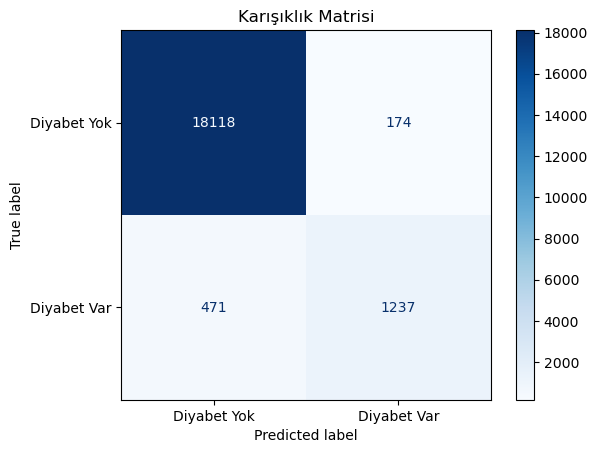

In [480]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Diyabet Yok", "Diyabet Var"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Karışıklık Matrisi")
plt.show()


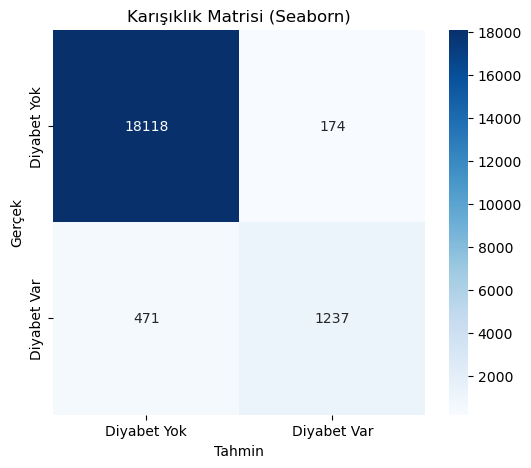

In [482]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Diyabet Yok", "Diyabet Var"], yticklabels=["Diyabet Yok", "Diyabet Var"])
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.title('Karışıklık Matrisi (Seaborn)')
plt.show()
